Tableau de correspondance (premiers 5 symboles) :
{'symbole': 0, 'bits': '0000', 'decimal': 0, 'I': 3.0, 'Q': 3.0, 'energie': 18.000000000000004, 'phase': 45.0}
{'symbole': 1, 'bits': '0001', 'decimal': 1, 'I': 1.0, 'Q': 3.0, 'energie': 10.000000000000002, 'phase': 71.56505117707799}
{'symbole': 2, 'bits': '0010', 'decimal': 2, 'I': -3.0, 'Q': 3.0, 'energie': 18.000000000000004, 'phase': 135.0}
{'symbole': 3, 'bits': '0011', 'decimal': 3, 'I': -1.0, 'Q': 3.0, 'energie': 10.000000000000002, 'phase': 108.43494882292202}
{'symbole': 4, 'bits': '0100', 'decimal': 4, 'I': 3.0, 'Q': 1.0, 'energie': 10.000000000000002, 'phase': 18.43494882292201}

Bilan d'énergie et phase: {'energie_moyenne': 10.000000000000002, 'energie_max': 18.000000000000004, 'energie_min': 2.0000000000000004, 'phase_moyenne': 0.0}


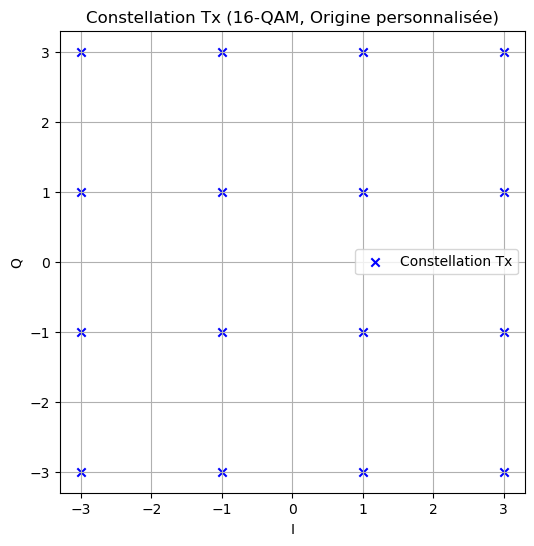

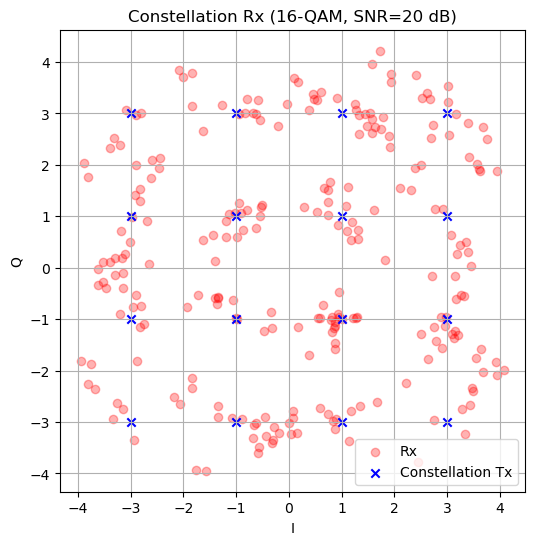


BER pour SNR = 20 dB (16-QAM): 3.20e-02


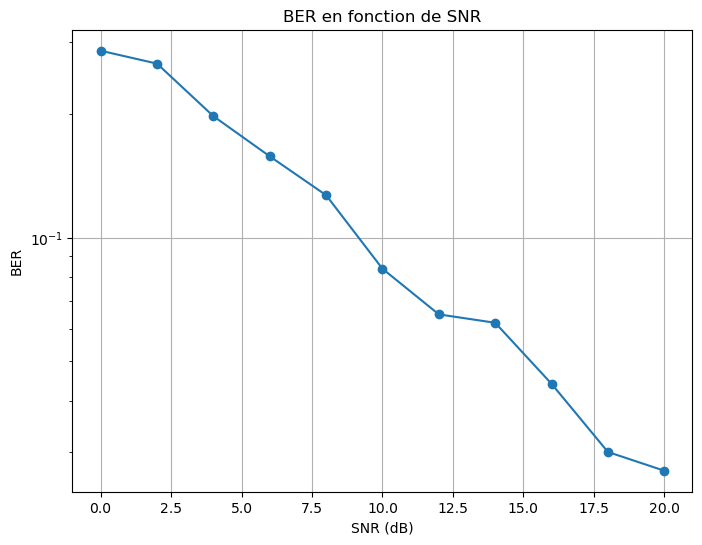

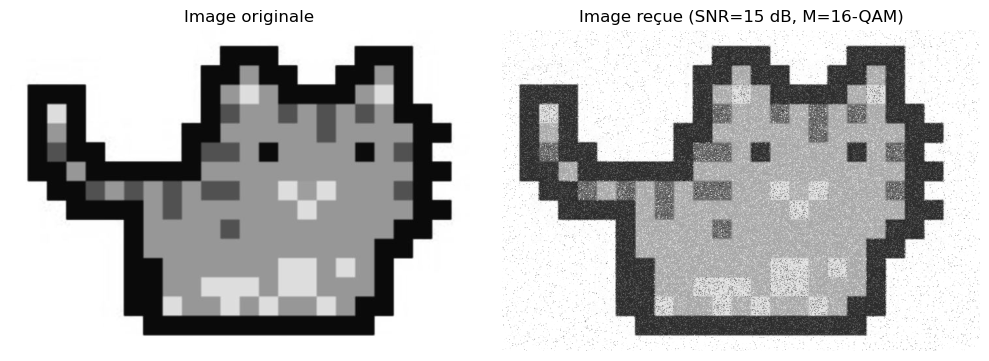


Transmission d'image QAM terminée.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class QAMModem:
    """
    Déclaration d'une classe nommée QAMModem, qui représente un modem utilisant la modulation QAM
    Cette classe regroupe toutes les méthodes nécessaires pour
    générer la constellation, moduler/démoduler des bits, ajouter du bruit (AWGN + bruit de phase),
    calculer le BER, et afficher les résultats. Elle permet ainsi de simuler un système de communication
    QAM de bout en bout.
    """
    def __init__(self, M, gray_code=True, custom_origin=False):
        """
        Initialise le modem QAM.

        Args:
            M (int): Le nombre de symboles dans la constellation (doit être une puissance de 2, et un carré parfait).
            gray_code (bool): Indique si le codage Gray doit être utilisé (par défaut: True).
            custom_origin (bool): Indique si l'origine de la constellation doit être personnalisée (par défaut: False).
        """
        if np.log2(M) % 1 != 0 or int(np.sqrt(M)) ** 2 != M:
            raise ValueError("M doit être une puissance de 2 et un carré parfait (4, 16, 64, ...).")
        self.M = M
        self.gray_code = gray_code
        self.custom_origin = custom_origin
        self.bits_per_symbol = int(np.log2(M))
        self.symbols = self.generate_constellation()
        self.symbol_map = self.create_symbol_map()

    def gray_mapping(self, sqrt_M):
        """
        Applique le codage Gray aux indices.

        Args:
            sqrt_M (int): La racine carrée de M.

        Returns:
            np.ndarray: Un tableau contenant les indices réordonnés selon le code Gray.
        """
        gray = lambda n: n ^ (n >> 1)
        gray_indices = [gray(i) for i in range(sqrt_M)]
        gray_grid = np.array(np.meshgrid(gray_indices, gray_indices)).T.reshape(-1, 2)
        return gray_grid[:, 0] * sqrt_M + gray_grid[:, 1]

    def generate_constellation(self):
        """
        Génère les points de la constellation QAM en répartissant les symboles
        sur une grille carrée en quadrature d'amplitude. La constellation est 
        normalisée pour que la puissance moyenne soit égale à 1.
        """
        sqrt_M = int(np.sqrt(self.M))
        x = np.linspace(-(sqrt_M - 1), sqrt_M - 1, sqrt_M)
        if self.custom_origin:
            x = x[::-1]  # Inverse la direction pour changer l'origine

        I, Q = np.meshgrid(x, x)
        constellation = (I + 1j * Q).flatten()

        if self.gray_code:
            gray_order = self.gray_mapping(sqrt_M)
            constellation = constellation[gray_order]

        return constellation

    def create_symbol_map(self):
        """
        Crée un tableau de correspondance entre les symboles et leurs représentations binaires, décimales, I/Q, énergie et phase.

        Returns:
            list: Une liste de dictionnaires, où chaque dictionnaire représente un symbole.
        """
        symbol_map = []
        for i, symbol in enumerate(self.symbols):
            bits = np.binary_repr(i, width=self.bits_per_symbol)
            symbol_map.append({
                'symbole': i,
                'bits': bits,
                'decimal': i,
                'I': np.real(symbol),
                'Q': np.imag(symbol),
                'energie': np.abs(symbol)**2,
                'phase': np.angle(symbol, deg=True)
            })
        return symbol_map

    def bilan_energie_phase(self):
        """
        Calcule le bilan des énergies et des phases de la constellation.

        Returns:
            dict: Un dictionnaire contenant l'énergie moyenne, maximale, minimale et la phase moyenne.
        """
        energies = [entry['energie'] for entry in self.symbol_map]
        phases = [entry['phase'] for entry in self.symbol_map]
        return {
            'energie_moyenne': np.mean(energies),
            'energie_max': np.max(energies),
            'energie_min': np.min(energies),
            'phase_moyenne': np.mean(phases)
        }

    def modulate(self, bits):
        """
        Convertit une séquence de bits en symboles QAM.
     Paramètre :
    - bits : tableau de bits à moduler (longueur multiple de log2(M)).

    Retour :
    - Liste de symboles complexes appartenant à la constellation QAM.
    """
        symbols = []
        for i in range(0, len(bits), self.bits_per_symbol):
            chunk = bits[i:i+self.bits_per_symbol]
            if len(chunk) < self.bits_per_symbol:
                chunk += '0' * (self.bits_per_symbol - len(chunk)) # Padding si nécessaire
            idx = int(chunk, 2)
            symbols.append(self.symbols[idx])
        return np.array(symbols)

    def demodulate(self, received_signal):
        """
        Démodule un signal QAM reçu en une séquence de bits.

         Paramètre :
    - symbols : symboles reçus (complexes) à démoduler.

    Retour :
    - Tableau de bits démodulés à partir des symboles.
    """
        bits = []
        for symbol in received_signal:
            distances = np.abs(self.symbols - symbol)
            idx = np.argmin(distances)
            bits.append(np.binary_repr(idx, width=self.bits_per_symbol))
        return ''.join(bits)

    def add_awgn_and_phase(self, signal, snr_db, phase_noise_amplitude=np.pi/8):
        """
        Ajoute du bruit blanc gaussien additif (AWGN) et du bruit de phase au signal.

        Args:
            signal (np.ndarray): Le signal QAM.
            snr_db (float): Le rapport signal sur bruit en décibels.
            phase_noise_amplitude (float): L'amplitude maximale du bruit de phase (en radians).

        Returns:
            np.ndarray: Le signal avec bruit AWGN et bruit de phase ajoutés.
        """
        snr_linear = 10 ** (snr_db / 10)
        puissance_signal = np.mean(np.abs(signal) ** 2)
        puissance_bruit = puissance_signal / snr_linear
        bruit = np.sqrt(puissance_bruit / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
        phi = np.random.uniform(-phase_noise_amplitude, phase_noise_amplitude, size=len(signal))
        phase_noise = np.exp(1j * phi)
        return (signal * phase_noise) + bruit

    def calculate_ber(self, original_bits, received_bits):
        """
        Calcule le taux d'erreur binaire (BER) entre les bits envoyés et reçus.

        Args:
            original_bits (str): La séquence de bits originale.
            received_bits (str): La séquence de bits reçue.

        Returns:
            float: Le taux d'erreur binaire.
        """
        errors = sum(1 for a, b in zip(original_bits, received_bits) if a != b)
        return errors / len(original_bits)

    def plot_constellation(self, signal, title):
        """
        Affiche la constellation des symboles.

        Args:
            signal (np.ndarray): Le signal QAM à afficher.
            title (str): Le titre du graphique.
        """
        plt.figure(figsize=(6, 6))
        plt.scatter(np.real(signal), np.imag(signal), color='red', alpha=0.3, label='Rx')
        plt.scatter(np.real(self.symbols), np.imag(self.symbols), color='blue', marker='x', label='Constellation Tx')
        plt.title(title)
        plt.xlabel('I')
        plt.ylabel('Q')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_ber_vs_snr(self, bits, snr_range):
        """
        Trace le BER en fonction du SNR.

        Args:
            bits (str): La séquence de bits à transmettre.
            snr_range (np.ndarray): Un tableau de valeurs SNR (en dB) à tester.
        """
        ber_values = []
        for snr_db in snr_range:
            tx = self.modulate(bits)
            rx = self.add_awgn_and_phase(tx, snr_db)
            rx_bits = self.demodulate(rx)
            ber = self.calculate_ber(bits, rx_bits)
            ber_values.append(ber)
        plt.figure(figsize=(8, 6))
        plt.plot(snr_range, ber_values, marker='o')
        plt.title("BER en fonction de SNR")
        plt.xlabel("SNR (dB)")
        plt.ylabel("BER")
        plt.grid(True)
        plt.yscale('log')
        plt.show()

def apply_qam_to_image(image_path, M, snr_db):
    """
    Applique la modulation et la démodulation QAM à une image en niveaux de gris.

    Args:
        image_path (str): Le chemin vers le fichier image.
        M (int): L'ordre de la modulation QAM (nombre de symboles).
        snr_db (float): Le rapport signal sur bruit en décibels pour le canal.

    Returns:
        tuple: Un tuple contenant l'image originale (numpy array) et l'image reconstruite (numpy array).
    """
    # 1. Charger l'image (grayscale)
    try:
        img = Image.open(image_path).convert("L")  # Niveau de gris
        img_array = np.array(img)
        img_shape = img_array.shape
    except FileNotFoundError:
        print(f"Erreur: Le fichier image '{image_path}' n'a pas été trouvé.")
        return None, None

    # 2. Convertir en bits
    flat_pixels = img_array.flatten()
    bits = ''.join([np.binary_repr(pix, width=8) for pix in flat_pixels])

    # 3. Instancier le modem
    modem = QAMModem(M=M, gray_code=True)

    # 4. Moduler
    tx_symbols = modem.modulate(bits)

    # 5. Ajouter bruit
    rx_symbols = modem.add_awgn_and_phase(tx_symbols, snr_db)

    # 6. Démoduler
    rx_bits = modem.demodulate(rx_symbols)

    # 7. Reconstruire l'image
    n_pixels = len(flat_pixels)
    rx_bits = rx_bits[:n_pixels * 8]  # Enlever le surplus de bits (si la longueur n'est pas multiple de bits/symbole)
    rx_pixels = [int(rx_bits[i:i+8], 2) for i in range(0, len(rx_bits), 8)]
    rx_array = np.array(rx_pixels, dtype=np.uint8).reshape(img_shape)

    # 8. Affichage
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image originale")
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Image reçue (SNR={snr_db} dB, M={M}-QAM)")
    plt.imshow(rx_array, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_array, rx_array

if __name__ == "__main__":
    # Paramètres du modem
    M = 16  # Nombre de symboles QAM
    snr_db = 20  # Rapport signal sur bruit en dB

    # Instanciation du modem
    modem = QAMModem(M=M, gray_code=True, custom_origin=True)

    # 3. Génération du tableau de correspondance (premiers 5 symboles)
    print("Tableau de correspondance (premiers 5 symboles) :")
    for entry in modem.symbol_map[:5]:
        print(entry)

    # 4. Calcul du bilan d'énergie et de phase
    bilan = modem.bilan_energie_phase()
    print("\nBilan d'énergie et phase:", bilan)

    # 5. Constellation Tx (avec option d'origine personnalisée)
    plt.figure(figsize=(6, 6))
    plt.scatter(np.real(modem.symbols), np.imag(modem.symbols), color='blue', marker='x', label='Constellation Tx')
    plt.title(f"Constellation Tx ({M}-QAM, Origine {'personnalisée' if modem.custom_origin else 'standard'})")
    plt.xlabel('I')
    plt.ylabel('Q')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Simulation de transmission de bits
    num_bits = 1000
    bits = ''.join(np.random.choice(['0', '1'], size=num_bits))
    tx_symbols = modem.modulate(bits)

    # 6. Constellation Rx (ajout de bruit AWGN et phase)
    rx_symbols = modem.add_awgn_and_phase(tx_symbols, snr_db)
    modem.plot_constellation(rx_symbols, f"Constellation Rx ({M}-QAM, SNR={snr_db} dB)")

    # 7. Calcul du BER et SNR (le SNR est un paramètre d'entrée)
    rx_bits = modem.demodulate(rx_symbols)
    ber = modem.calculate_ber(bits, rx_bits)
    print(f"\nBER pour SNR = {snr_db} dB ({M}-QAM): {ber:.2e}")

    # 8. Représentation du BER en fonction du SNR
    snr_range = np.arange(0, 21, 2)
    modem.plot_ber_vs_snr(bits[:10000], snr_range) # Utiliser une séquence de bits plus longue pour une meilleure estimation du BER

    # 9. Application du modem QAM à une transmission d'image
    image_path = "image.jpg"  # Remplacez par le chemin de votre image
    original_image, received_image = apply_qam_to_image(image_path, M=16, snr_db=15)
    if original_image is not None and received_image is not None:
        print("\nTransmission d'image QAM terminée.")

  